In [1]:
# Импортируем библиотеки

import pandahouse
import pandas as pd
import seaborn as sns
from scipy import stats

## A/A тест

In [2]:
# Выгружаем пользователей, которые участвовали в A/A тесте из групп 2 и 3

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230720',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

q = """
SELECT
  exp_group,
  user_id,
  sum(action = 'like') as likes,
  sum(action = 'view') as views,
  likes / views as ctr
FROM
  simulator_20230720.feed_actions
WHERE
  toDate(time) between '2023-06-23'
  and '2023-06-29'
  and exp_group in (2, 3)
GROUP BY
  exp_group,
  user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [3]:
df

,exp_group,user_id,likes,views,ctr
0,3,115383,38,248,0.153226
1,3,10326,24,132,0.181818
2,3,123580,25,122,0.204918
3,2,131473,19,98,0.193878
4,2,23985,12,44,0.272727
...,...,...,...,...,...
16782,3,122008,20,123,0.162602
16783,2,25383,2,18,0.111111
16784,3,122190,15,56,0.267857
16785,2,108927,16,51,0.313725


In [4]:
# Считаем число пользователей в группах
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8362,8362,8362,8362
3,8425,8425,8425,8425


In [8]:
sns.set(rc={'figure.figsize': (18, 12) })

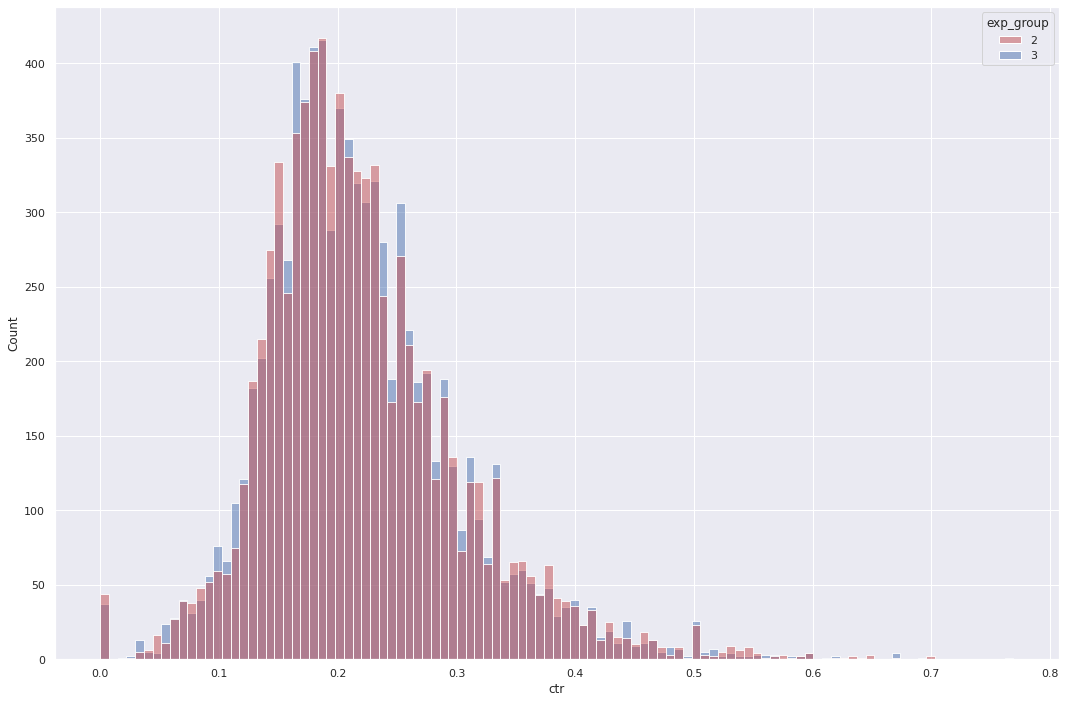

In [9]:
# визуализируем распредление ctr в дыух группах пользователей

groups = sns.histplot(data=df,
                      x='ctr',
                      hue='exp_group',
                      palette=['r', 'b'],
                      alpha=0.5,
                      kde=False)

In [7]:
# Сравним статистически распределения ctr в двух группах пользователей

stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.6617303509169772, pvalue=0.5081531382926275)

Ни визуально, ни статистически нет различий группами пользователей 2 и 3

## Проведем 10000 A/A тестов

In [10]:
# Проведем 10000 A/A тестов на выборказ по 500 пользователей из групп 2 и 3

p_values = []

for _ in range(10000):
    sample_1 = df[df.exp_group == 2].sample(500, replace=True)
    sample_2 = df[df.exp_group == 3].sample(500, replace=True)
    p_value = stats.ttest_ind(sample_1.ctr,
                sample_2.ctr,
                equal_var=False)[1]
    p_values.append(p_value)

<Axes: ylabel='Count'>

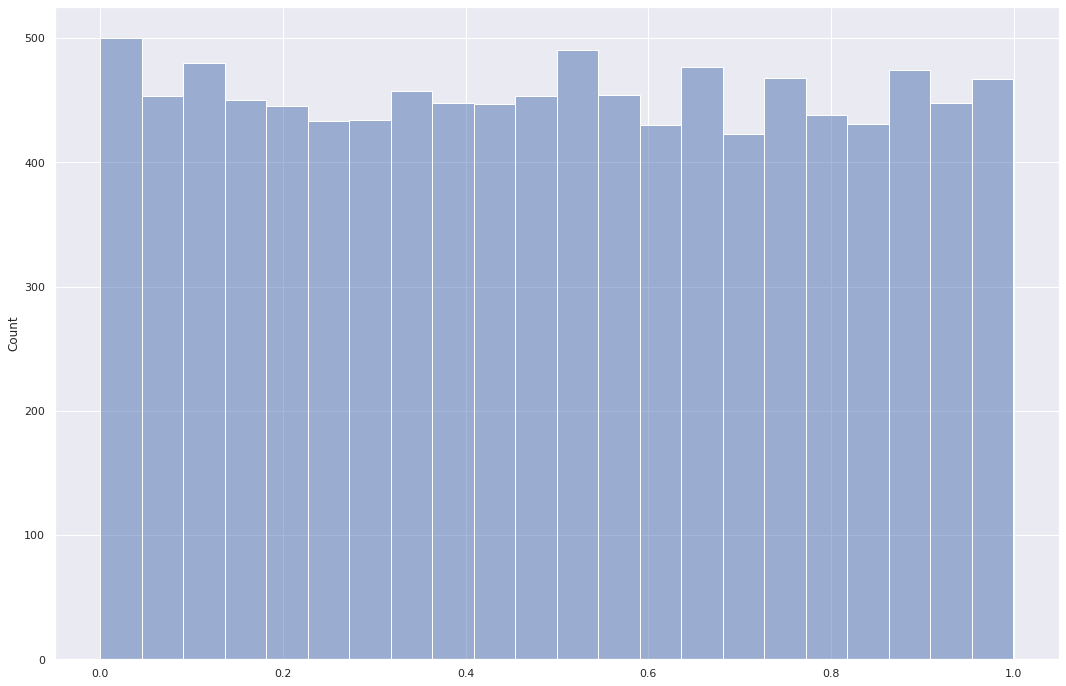

In [11]:
# Визуализация распределения полученных p values в 10000 тестах

sns.histplot(data=p_values,
                      alpha=0.5,
                      kde=False)

In [12]:
# Подсчет количества p values, которые меньше либо равны 0.05

count = 0

for p_value in p_values:
    if p_value <= 0.05:
        count += 1
print(f"{100 * count / len(p_values)}% p values оказались меньше либо равены 0.05")

5.53% p values оказались меньше либо равены 0.05


## Вывод
Значения p values распределены примерно равномерно. Всего 5% p values оказались меньше или равны 0.05. Таким образом, наша сисетма сплитования корректна.